# Code for generating Figure 6 from derivative data

#### Raw code for generating derivative data is in 
`analysis5_model_traindat1dat2_richVsLazyLearning.py`
#### Batch script is in:
`analysis5_batch.sh`, line 35

#### Example command (within batch)

`python analysis5_model_traindat1dat2_richVsLazyLearning.py --weight_init 1.0 --bias_init 0 --nhidden 500 --normalize --cuda --outfilename analysis5_run${SLURM_ARRAY_TASK_ID}`

Note that weight_init needs to be varied according to parameters reported in Methods (0.2 to 2.0, in 0.2 increments)

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In [13]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc

#### Set up basic parameters

In [3]:
figuredir = '../figures/Fig6/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Visualize input and output regions

Similarity between V1 and input RSM (0.6095873684001054, 2.4079535546003772e-206)
Similarity between M1 and output RSM (0.7198705049175375, 4e-323)


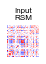

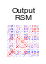

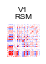

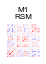

In [8]:
parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')

h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()
h5f.close()
# Average across subjects
rsms_avg = np.mean(rsms_subj,axis=1)

in_ind = np.where(parcellated_gradients[:,1]==np.min(parcellated_gradients[:,1]))[0][0]
out_ind = np.where(parcellated_gradients[:,1]==np.max(parcellated_gradients[:,1]))[0][0]

in_rsm = rsms_avg[in_ind,:,:]
out_rsm = rsms_avg[out_ind,:,:]

vmin, vmax = np.min([in_rsm,out_rsm]), np.max([in_rsm,out_rsm])

plt.figure(figsize=(1,1))
ax = sns.heatmap(in_rsm,square=True,vmin=vmin,vmax=vmax,center=0,cmap='bwr',cbar=False,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('Input\nRSM',fontsize=8)
plt.tight_layout()
plt.savefig(figuredir + 'InputRSM.pdf',transparent=True)

plt.figure(figsize=(1,1))
ax = sns.heatmap(out_rsm,square=True,vmin=vmin,vmax=vmax,center=0,cmap='bwr',cbar=False,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('Output\nRSM',fontsize=8)
plt.tight_layout()
plt.savefig(figuredir + 'OutputRSM.pdf',transparent=True)



#####
# Plot on surface
tmp_vertex64k = np.zeros((len(glasser),))
in_ind_64 = np.where(glasser==in_ind+1)[0]
out_ind_64 = np.where(glasser==out_ind+1)[0]
tmp_vertex64k[in_ind_64] = -1
tmp_vertex64k[out_ind_64] = 1
tmpfilename = figuredir + 'InputOutputHierarchicalRegions'
if not os.path.exists(tmpfilename + '.dscalar.nii'):
    np.savetxt(tmpfilename + '.csv', tmp_vertex64k, fmt='%s')
    wb_file = tmpfilename + '.dscalar.nii'
    wb_command = 'wb_command -cifti-convert -from-text ' + tmpfilename + '.csv ' + glasserfilename + ' ' + wb_file + ' -reset-scalars'
    os.system(wb_command)
    os.remove(tmpfilename + '.csv')


##### Plot Right V1 and Right M1
r_v1 = 180
r_m1 = 187
tmp_vertex64k = np.zeros((len(glasser),))
in_ind_64 = np.where(glasser==r_v1+1)[0]
out_ind_64 = np.where(glasser==r_m1+1)[0]
tmp_vertex64k[in_ind_64] = -1
tmp_vertex64k[out_ind_64] = 1
tmpfilename = '../figures/SFig6/V1andM1Regions'
if not os.path.exists(tmpfilename + '.dscalar.nii'):
    np.savetxt(tmpfilename + '.csv', tmp_vertex64k, fmt='%s')
    wb_file = tmpfilename + '.dscalar.nii'
    wb_command = 'wb_command -cifti-convert -from-text ' + tmpfilename + '.csv ' + glasserfilename + ' ' + wb_file + ' -reset-scalars'
    os.system(wb_command)
    os.remove(tmpfilename + '.csv')
    
    
v1_rsm = rsms_avg[r_v1,:,:]
m1_rsm = rsms_avg[r_m1,:,:]

vmin, vmax = np.min([v1_rsm,m1_rsm]), np.max([v1_rsm,m1_rsm])

plt.figure(figsize=(1,1))
ax = sns.heatmap(v1_rsm,square=True,vmin=vmin,vmax=vmax,center=0,cmap='bwr',cbar=False,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('V1\nRSM',fontsize=8)
plt.tight_layout()
plt.savefig('../figures/SFig6/V1_RSM.pdf',transparent=True)

plt.figure(figsize=(1,1))
ax = sns.heatmap(m1_rsm,square=True,vmin=vmin,vmax=vmax,center=0,cmap='bwr',cbar=False,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('M1\nRSM',fontsize=8)
plt.tight_layout()
plt.savefig('../figures/SFig6/M1_RSM.pdf',transparent=True)

print('Similarity between V1 and input RSM', stats.pearsonr(v1_rsm.reshape(-1),in_rsm.reshape(-1)))
print('Similarity between M1 and output RSM', stats.pearsonr(m1_rsm.reshape(-1),out_rsm.reshape(-1)))



# Model params to load data from

In [10]:
nhidden = 500
nlayers = 10
outfilename = 'analysis5_run'
bias_init = '_biasinit0.0'
relu = ''
optim = '_optimadam'
normalize = '_normalize'
weight_init_range = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
untied = ''
nsimulations = 20

# Load dimensionality of different initial weight conditions

In [14]:
df_dim_group = pd.DataFrame()
for weightinit in weight_init_range:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + relu + normalize
        try:
            df_dim = pd.read_csv('../processed_data/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv')

            tmpdf = df_dim.groupby('Layer',as_index=False).mean()
            tmpdf.insert(loc=0,column='WeightInit', value=np.repeat(weightinit,12))
            tmpdf.insert(loc=0,column='Simulation', value=np.repeat(sim,12))

            df_dim_group = df_dim_group.append(tmpdf)
            # Insert new columns

        
del df_dim_group['Subject'], df_dim_group['Unnamed: 0']
        
    


# Plot dimensionality for weight initializations

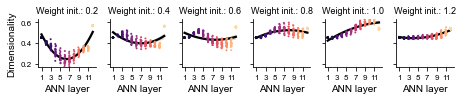

In [16]:
weights_to_plot = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
plt.figure(figsize=(6.5,1.5))

i = 1
for weight in weights_to_plot:
    plt.subplot(1,6,i)
    tmpdf = df_dim_group.loc[df_dim_group.WeightInit==weight]
    # Need to reset layer values so plotted correctly with regplot
    layers = tmpdf.Layer.values - 1
    del tmpdf['Layer']
    tmpdf.insert(loc=0,column='Layer', value=layers)
    sns.stripplot(x="Layer",y="Dimensionality",data=tmpdf,palette='magma',size=2)
    sns.regplot(x="Layer",y="Dimensionality",data=tmpdf,color='k',order=2,scatter=False)
    plt.xlabel('ANN layer',fontsize=10)
    plt.title('Weight init.: ' + str(weight),fontsize=9)
    if i == 1:
        plt.yticks([0.2,.4,.6], [.2, .4, .6],fontsize=8)
        plt.ylabel('Dimensionality',fontsize=10)      
    else:
        plt.yticks([.2,.4,.6],[])
        plt.ylabel(None)
    plt.xticks(np.arange(0,12,2),np.arange(1,13,2),fontsize=8)

    plt.ylim([0.17,0.63])
    i += 1
sns.despine()
plt.tight_layout()
plt.savefig(figuredir + 'DimensionalityXLayerWeightInitialization.pdf',transparent=True)

              


#### For each 2nd order fit, evaluate the quadratic coeffcient magnitude and the r-squared

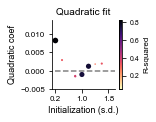

In [18]:
df_fit  = {}
df_fit['R-squared'] = []
df_fit['Quadratic coef'] = []
df_fit['Weight init.'] = []
for weight in weight_init_range:

    tmpdf = df_dim_group.loc[df_dim_group.WeightInit==weight]

    # 
    x = tmpdf.Layer.values
    x.shape = (len(x),1)
    y = tmpdf.Dimensionality.values
    ## 2nd order model
    polynomial_features = PolynomialFeatures(degree=2)
    xp2 = polynomial_features.fit_transform(x)

    #fit regression model
    model2 = sm.OLS(y, xp2).fit()

    df_fit['R-squared'].append(model2.rsquared)
    df_fit['Quadratic coef'].append(model2.params[2])
    df_fit['Weight init.'].append(weight)
df_fit = pd.DataFrame(df_fit)

color3 = sns.color_palette('Set2')[2]
plt.figure(figsize=(2.2,1.8))
ax = sns.scatterplot(x="Weight init.", y="Quadratic coef", data=df_fit, hue="R-squared", size="R-squared",sizes=(0,75),alpha=1, label='2nd coef.',palette='magma_r',legend=False,linewidth=3,color=color3)
ax.set_xlabel('Initialization (s.d.)',fontsize=9)
ax.set_ylabel('Quadratic coef', color='k',fontsize=9)
plt.plot(weight_init_range,np.repeat(0,len(weight_init_range)),'--',color='grey')
ax.tick_params(axis='y', labelcolor='k')
ax.set_xticks(np.arange(0.2,2.0,0.8))
ax.set_ylim([-0.005,0.014])
ax.set_xlim([0.1,2.0])
ax.set_title('Quadratic fit',fontsize=10)
ax.tick_params(labelsize=8)
#
norm = plt.Normalize(df_fit['R-squared'].min(), df_fit['R-squared'].max())
smap = plt.cm.ScalarMappable(cmap="magma_r", norm=norm)
smap.set_array([])
cax = ax.figure.colorbar(smap)
cax.ax.tick_params(labelsize=7)
cax.ax.set_ylabel('R-squared', fontsize=8);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + '2ndCoefRsquaredXInitializationSD.pdf',transparent=True)


# Compare model produced RSMs with hierarchical empirical RSMs

#### Load in empirical RSMs and compute each region's representational similarity with each layer's representational similarity

In [27]:
# Load in ANN RSMs    
h5f = h5py.File('../processed_data/analysis5_tiedweights/analysis5_ann_representations.h5','r')
rsms_model = h5f['data'][:].copy()
h5f.close()

# Load emiprical RSMs
h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()
h5f.close()
rsms_empirical = np.mean(np.arctanh(rsms_subj),axis=1)

# Load RSM gradients
rsm_gradients = np.loadtxt('../processed_data/analysis1/analysis1_cosine_3components_cosineRSMs_representational_gradients.csv')
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality.csv')
# Load empirical dimensionality
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)

nParcels = rsms_empirical.shape[0]
numlayers = rsms_model.shape[2]
ntasks = 45
triu_ind = np.triu_indices(ntasks,k=0)

ann_brain_rsm_match = np.zeros((nParcels,numlayers,nsimulations,len(weight_init_range)))
for sim in range(nsimulations):
    for weight_ind in range(len(weight_init_range)):
        for layer in range(numlayers):
            for parcel in range(nParcels):
                ann_brain_rsm_match[parcel,layer,sim,weight_ind] = np.dot(rsms_empirical[parcel][triu_ind],rsms_model[weight_ind,sim,layer][triu_ind])/(np.linalg.norm(rsms_empirical[parcel][triu_ind])*np.linalg.norm(rsms_model[weight_ind,sim,layer][triu_ind]))

                


Rich cosine: 0.42076094887638954
Lazy cosine: 0.3692121053830424
Average cosine difference: 0.051548843493347124
	 t = 15.283829518708066 | p = 2.1364011618110006e-35


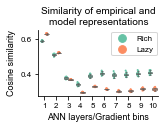

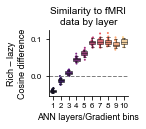

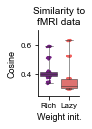

In [28]:
n_hierarchy_bins = 10

bin_stepsize = 36
sorted_hierarchy = sorted(range(len(rsm_gradients[:,0])), key=lambda k: rsm_gradients[:,0][k])

df_annbrainsimilarity = {}
df_annbrainsimilarity['Layer'] = []
df_annbrainsimilarity['Weight initialization'] = []
df_annbrainsimilarity['Representational similarity'] = []
df_annbrainsimilarity['Simulation'] = []

binstart = 0
for bins in range(n_hierarchy_bins):
    bin_ind = sorted_hierarchy[binstart:binstart+bin_stepsize]
    for sim in range(nsimulations):
        rich_ind = np.where(np.asarray(weight_init_range)<1.0)[0]
        lazy_ind = np.where(np.asarray(weight_init_range)>1.0)[0]
        df_annbrainsimilarity['Layer'].append(bins)
        df_annbrainsimilarity['Simulation'].append(sim)
        df_annbrainsimilarity['Weight initialization'].append('Rich')
        binned_avg_rich = np.mean(ann_brain_rsm_match[bin_ind],axis=0)
        df_annbrainsimilarity['Representational similarity'].append(np.mean(binned_avg_rich[bins+1,sim,rich_ind],axis=0))
        #
        df_annbrainsimilarity['Layer'].append(bins)
        df_annbrainsimilarity['Simulation'].append(sim)
        df_annbrainsimilarity['Weight initialization'].append('Lazy')
        binned_avg_lazy = np.mean(ann_brain_rsm_match[bin_ind],axis=0)
        df_annbrainsimilarity['Representational similarity'].append(np.mean(binned_avg_lazy[bins+1,sim,lazy_ind],axis=0))   
        
    binstart += bin_stepsize
df_annbrainsimilarity = pd.DataFrame(df_annbrainsimilarity)


df_similaritydiff = {}
df_similaritydiff['Layer'] = []
df_similaritydiff['Representational similarity'] = []
df_similaritydiff['Simulation'] = []

binstart = 0
for bins in range(n_hierarchy_bins):
    bin_ind = sorted_hierarchy[binstart:binstart+bin_stepsize]
    for sim in range(nsimulations):
        rich_ind = np.where(np.asarray(weight_init_range)<1.0)[0]
        lazy_ind = np.where(np.asarray(weight_init_range)>1.0)[0]
        df_similaritydiff['Layer'].append(bins)
        df_similaritydiff['Simulation'].append(sim)
        binned_avg = np.mean(ann_brain_rsm_match[bin_ind],axis=0)
        diff = np.mean(binned_avg[bins+1,sim,rich_ind],axis=0) - np.mean(binned_avg[bins+1,sim,lazy_ind],axis=0)
        df_similaritydiff['Representational similarity'].append(diff)
        
    binstart += bin_stepsize
df_similaritydiff = pd.DataFrame(df_similaritydiff)

plt.figure(figsize=(2.4,1.9))
ax = sns.boxplot(x="Layer",y="Representational similarity",hue="Weight initialization",data=df_annbrainsimilarity,palette='Set2',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
sns.stripplot(x="Layer",y="Representational similarity",hue="Weight initialization",data=df_annbrainsimilarity,dodge=True,palette='Set2',size=2,zorder=0)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0.2, prop={'size': 8})
plt.xlabel('ANN layers/Gradient bins',fontsize=9)
plt.ylabel('Cosine similarity', fontsize=9)
plt.xticks(np.arange(10),np.arange(1,11),fontsize=8)
plt.yticks(fontsize=8)
plt.title('Similarity of empirical and\nmodel representations', fontsize=10)
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'RichVsLazyLearningBrainANNComparison.pdf',transparent=True)

plt.figure(figsize=(2.1,1.9))
ax = sns.boxplot(x="Layer",y="Representational similarity",data=df_similaritydiff,palette='magma',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
sns.stripplot(x="Layer",y="Representational similarity",data=df_similaritydiff,dodge=True,palette='magma',size=2,zorder=0)
plt.plot(np.arange(-0.5,10.5),np.repeat(0,11),linestyle='--',color='gray',linewidth=1)
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0.2, prop={'size': 8})
plt.xlabel('ANN layers/Gradient bins',fontsize=9)
plt.ylabel('Rich – lazy\nCosine difference', fontsize=9)
plt.xticks(np.arange(10),np.arange(1,11),fontsize=8)
plt.yticks(fontsize=8)
plt.title('Similarity to fMRI\ndata by layer', fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RichVsLazyLearningBrainANNComparison_Difference.pdf',transparent=True)

plt.figure(figsize=(1.3,1.9))
ax = sns.boxplot(x="Weight initialization",y="Representational similarity",data=df_annbrainsimilarity,palette='magma',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
sns.stripplot(x="Weight initialization",y="Representational similarity",data=df_annbrainsimilarity,dodge=True,palette='magma',size=2,zorder=0)
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0.2, prop={'size': 8})
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Cosine', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0.25,0.7])
plt.title('Similarity to\nfMRI data', fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RichVsLazyLearning2Comparison.pdf',transparent=True)

### Run t-test
tmpdf_rich = df_annbrainsimilarity.loc[df_annbrainsimilarity["Weight initialization"]=='Rich']
tmpdf_lazy = df_annbrainsimilarity.loc[df_annbrainsimilarity["Weight initialization"]=='Lazy']
t, p = stats.ttest_rel(tmpdf_rich['Representational similarity'].values,tmpdf_lazy['Representational similarity'].values)
print('Rich cosine:', np.mean(tmpdf_rich['Representational similarity'].values))
print('Lazy cosine:', np.mean(tmpdf_lazy['Representational similarity'].values))
print('Average cosine difference:', np.mean(tmpdf_rich['Representational similarity'].values - tmpdf_lazy['Representational similarity'].values))
print('\t t =', t, '| p =', p)

#### Statistical testing of rich v lazy learning at each layer

In [29]:
ts, ps = [], []
for layer in np.unique(df_annbrainsimilarity.Layer.values):
    tmpdf = df_annbrainsimilarity.loc[df_annbrainsimilarity.Layer==layer]
    tmpdf_rich = tmpdf.loc[tmpdf['Weight initialization']=='Rich']
    tmpdf_lazy = tmpdf.loc[tmpdf['Weight initialization']=='Lazy']
    t, p = stats.ttest_rel(tmpdf_rich['Representational similarity'].values,tmpdf_lazy['Representational similarity'].values)
    ts.append(t)
    ps.append(p)

h0, qs = mc.fdrcorrection0(ps)

for layer in np.unique(df_annbrainsimilarity.Layer.values):
    print('Layer', layer+1, 't =', ts[layer], '| q =', qs[layer])

Layer 1 t = -45.74071912135192 | q = 1.8705605575046076e-20
Layer 2 t = -9.418745256525293 | q = 1.520682585072393e-08
Layer 3 t = 7.78211850383055 | q = 2.5194707956154994e-07
Layer 4 t = 31.319197288247697 | q = 1.0142196451798307e-17
Layer 5 t = 35.61508850145678 | q = 1.0481971426582001e-18
Layer 6 t = 56.64955871646611 | q = 1.1778261672904734e-21
Layer 7 t = 44.0222622057001 | q = 2.741126722082862e-20
Layer 8 t = 45.460325958056416 | q = 1.8705605575046076e-20
Layer 9 t = 43.53071579023923 | q = 2.8218628568223123e-20
Layer 10 t = 53.187435382838764 | q = 1.937785613679133e-21


# Visualize the partioning of the Margulies gradients into 10 surface maps

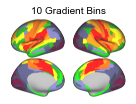

In [36]:
plt.figure(figsize=(2,2))
im = img.imread(figuredir + 'GradientBinningROIs.png') 
plt.imshow(im)
plt.axis('off')
plt.title('10 Gradient Bins',fontsize=10)
plt.tight_layout()
plt.savefig(figuredir + 'GradientBinningROIs_Fig.png',dpi=300,transparent=True)